<a href="https://colab.research.google.com/github/depersisc/Python-scripts/blob/master/Copia_di_beginner_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study 6.1 - NYC Taxi Trips

<h1 style="color:red;">Note: If you close this notebook at any time, you will have to run all cells again upon re-opening it.</h1>

<h1 style="color:red;">Note: You may get different numerical results running the notebook different times. This is to be expected, you can just report whatever results you get.</h1>

# BEGINNER PYTHON

As this is a beginner version, we include a lot of code here to help you along the way.

**First, fill in your identification information below. Then, you only have to type in the answers to the questions we ask you. For the rest of the cells, just Run them by pressing the "Run" button above.**

# Identification Information

You can find your MITxPro username on this [page](https://courses.xpro.mit.edu/courses/course-v1:xPRO+DSx+R14/progress) and copying the username in quotations after it says "Student". For example, Kevin's username is "kevin-lyons".

**Please use the correct username and the e-mail address right next to it as it makes it much easier for course staff to identify your notebook.**

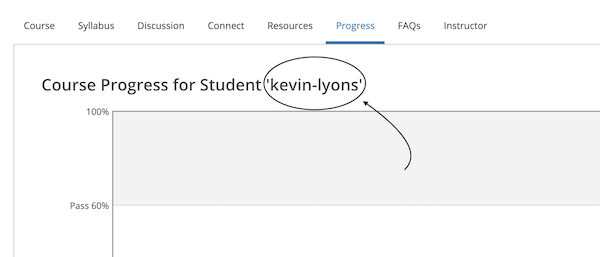

**YOUR NAME**              = fill in here

**YOUR MITX PRO USERNAME** = fill in here

**YOUR MITX PRO E-MAIL**   = fill in here

# Setup

Run these cells to install all the packages you need to complete the remainder of the case study. This may take a few minutes, so please be patient.

<h1 style="color:red;">Note: You may see red errors when you run the cell below. As long as you can run the Import cell 2 cells below and see "Install successful!" and "Import successful!", you can continue with the case study.</h1>

In [ ]:
!pip install -q --upgrade pip
!pip install -q featuretools==0.1.19 --use-feature=2020-resolver
!pip uninstall -y pandas
!pip install -q pandas==0.20.3 --use-feature=2020-resolver
print('Install successful!')

     |████████████████████████████████| 1.5MB 9.4MB/s 
     |████████████████████████████████| 133 kB 9.9 MB/s 
     |████████████████████████████████| 178 kB 18.2 MB/s 
     |████████████████████████████████| 91 kB 6.9 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
     |████████████████████████████████| 1.3 MB 20.1 MB/s 
     |████████████████████████████████| 6.5 MB 8.1 MB/s 
     |████████████████████████████████| 141 kB 65.1 MB/s 
     |████████████████████████████████| 295 kB 58.7 MB/s 
     |████████████████████████████████| 547 kB 63.8 MB/s 
ERROR: datascience 0.10.6 requires folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
Found existing installation: pandas 1.1.4
Uninstalling pandas-1.1.4:
  Successfully uninstalled pandas-1.1.4
     |████████████████████████████████| 24.5 MB 47 kB/s 
ERROR: xarray 0.15.1 requires pandas>=0.25, but you'll have pandas 0.20.3 which is incompatible.
seaborn 0.11.0 requires pandas>=0.23, but you'll have pandas 0.2

<h1>Now, you have to restart the runtime by clicking Runtime > Restart Runtime at the top of the page. This will ensure our changes take effect.</h1>

# Import

Import the required tools into the notebook.

In [ ]:
from google.colab import auth
auth.authenticate_user()

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
data_drop = drive.CreateFile({'id':'1OtzpLNq_s8UtWQgPXJEQX6ejJ92lEwkH'})
data_drop.GetContentFile('dropoff_neighborhoods.csv')
data_pick = drive.CreateFile({'id':'1CE8P9xjJYirrE3sN3xPp-Cc9wKYoNGxU'})
data_pick.GetContentFile('pickup_neighborhoods.csv')
data_trips = drive.CreateFile({'id':'19kUSme4S1hfcUJn3JovQd_mvw54il1QI'})
data_trips.GetContentFile('trips.pkl')
utils_file = drive.CreateFile({'id':'1_2324HvTia9NVkKY-j4RgWncct6gVnyi'})
utils_file.GetContentFile('utils.py')

In [ ]:
import featuretools as ft
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday,
                                     Weekend)
from sklearn.ensemble import GradientBoostingRegressor
from utils import (compute_features, feature_importances, load_nyc_taxi_data,
                   preview)
%matplotlib inline

print('Import successful!')

Import successful!


In [ ]:
assert ft.__version__ == '0.1.19', 'Make sure you run the command above with the correct version.'
assert pd.__version__ == '0.20.3', 'Make sure you run the command above with the correct version, AND restarted the runtime.'

# Data

Load the NYC taxi trip data. Note that this may take a minute or two, so please be patient.

In [ ]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)
print('Data load successful!')

Data load successful!


We can also plot some aspects of the data to get a better sense of its distributions. For instance, here is the `trip_duration` variable we are going to try to predict.

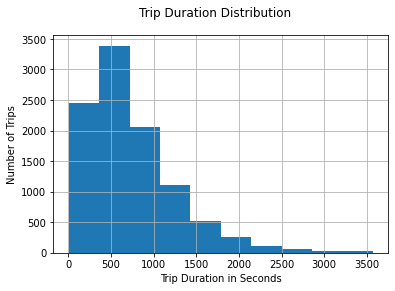

Histogram generation successful!


In [ ]:
trips.trip_duration.hist()
plt.xlabel('Trip Duration in Seconds')
plt.ylabel('Number of Trips')
plt.suptitle('Trip Duration Distribution')
plt.show()
print('Histogram generation successful!')

In [ ]:
trips.shape[0]  # Tells us how many trips are in the dataset

10000

<h1 style="color:red;">QUESTION 1: DATA ANALYSIS</h1>

**Describe the dataset. How many trips are in the dataset? How would you describe the distribution of trip durations? Is there anything else we should observe? Make sure the histogram is visible in the notebook.**

*Type your response here...*

# Entities and Relationships

In [ ]:
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

print('Entities and relationships successful!')

Entities and relationships successful!


# Transform Primitives

In [ ]:
trans_primitives = [Weekend]

# This may take some time to compute
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Transform primitives successful!')

Transform primitives successful!


Here are the features that we just created.

In [ ]:
print(f"Number of features: {len(features)}")
features

Number of features: 12


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Finally, we compute the feature matrix from these features.

In [ ]:
feature_matrix = compute_features(features)
preview(feature_matrix, 5)

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,vendor_id,pickup_neighborhoods.longitude,pickup_neighborhoods.latitude,IS_WEEKEND(pickup_datetime),IS_WEEKEND(dropoff_datetime),trip_distance,passenger_count,dropoff_neighborhoods.latitude,dropoff_neighborhood = D,dropoff_neighborhood = AA,...,pickup_neighborhood = E,pickup_neighborhood = M,pickup_neighborhood = AW,pickup_neighborhood = S,pickup_neighborhood = AF,pickup_neighborhood = T,pickup_neighborhood = AI,pickup_neighborhood = AE,pickup_neighborhood = B,pickup_neighborhood = AQ
id,,,,,,,,,,,,,,,,,,,,,
514030,2,-73.986446,40.757707,True,True,2.46,1,40.766809,0,0,...,0,0,0,0,0,0,0,0,0,0
514031,1,-73.919159,40.744928,True,True,7.90,2,40.793597,0,0,...,0,0,0,0,0,0,0,0,0,0
514032,1,-73.991595,40.729652,True,True,1.00,1,40.740333,0,0,...,0,0,0,0,0,0,0,0,0,0
514033,2,-73.987205,40.720245,True,True,0.02,1,40.720245,0,0,...,0,0,0,0,0,0,0,0,0,0
514034,1,-73.785073,40.646194,True,True,19.00,2,40.785005,0,0,...,0,0,0,0,0,0,0,0,0,0


# First Model

In [ ]:
# Split data
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Data split successful!')

Data split successful!


In [ ]:
# This should train within a minute or so
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # This is the R^2 value of the prediction

print('Training successful!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            1.99s
         2           0.4148            1.76s
         3           0.3661            1.70s
         4           0.3266            1.73s
         5           0.2934            1.73s
         6           0.2665            1.69s
         7           0.2441            1.65s
         8           0.2257            1.61s
         9           0.2103            1.58s
        10           0.1973            1.55s
        20           0.1433            1.33s
        30           0.1308            1.14s
        40           0.1252            0.96s
        50           0.1212            0.79s
        60           0.1187            0.63s
        70           0.1167            0.47s
        80           0.1155            0.31s
        90           0.1143            0.16s
       100           0.1133            0.00s
0.755458111784738
Training successful!


<h1 style="color:red;">QUESTION 2: FIRST MODEL</h1>

**Describe all the features that we added to the model. Do you think these improved the performance from a model that did not have these features? Why?**

*Type your response here...*

# More Transform Primitives

In [ ]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Transform primitives successful!')

Transform primitives successful!


In [ ]:
print(f"Number of features: {len(features)}")
features

Number of features: 24


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [ ]:
feature_matrix = compute_features(features)
preview(feature_matrix, 5)

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,IS_WEEKEND(pickup_datetime),MONTH(dropoff_datetime),passenger_count,DAY(dropoff_datetime),HOUR(dropoff_datetime),trip_distance,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = AC,pickup_neighborhood = AB,...,dropoff_neighborhoods.latitude,dropoff_neighborhoods.longitude,MONTH(pickup_datetime),WEEK(dropoff_datetime),pickup_neighborhoods.longitude,HOUR(pickup_datetime),MINUTE(dropoff_datetime),IS_WEEKEND(dropoff_datetime),MINUTE(pickup_datetime),WEEKDAY(dropoff_datetime)
id,,,,,,,,,,,,,,,,,,,,,
514030,True,4,1,2,0,2.46,1,0,0,0,...,40.766809,-73.956886,4,13,-73.986446,0,17,True,0,5
514031,True,4,2,2,0,7.90,0,0,0,0,...,40.793597,-73.969822,4,13,-73.919159,0,24,True,0,5
514032,True,4,1,2,0,1.00,0,0,0,0,...,40.740333,-74.005107,4,13,-73.991595,0,19,True,0,5
514033,True,4,1,2,0,0.02,0,0,1,0,...,40.720245,-73.987205,4,13,-73.987205,0,1,True,0,5
514034,True,4,2,2,0,19.00,0,0,0,0,...,40.785005,-73.976050,4,13,-73.785073,0,58,True,1,5


In [ ]:
# Re-split data
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Data split successful!')

Data split successful!


In [ ]:
# This should train within a minute or so
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # This is the R^2 value of the prediction

print('Training successful!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            2.31s
         2           0.4148            2.20s
         3           0.3661            2.12s
         4           0.3264            2.11s
         5           0.2930            2.06s
         6           0.2660            2.02s
         7           0.2432            1.99s
         8           0.2245            1.96s
         9           0.2090            1.94s
        10           0.1960            1.94s
        20           0.1362            1.70s
        30           0.1198            1.47s
        40           0.1124            1.24s
        50           0.1075            1.04s
        60           0.1044            0.82s
        70           0.1017            0.62s
        80           0.0999            0.41s
        90           0.0971            0.20s
       100           0.0936            0.00s
0.8013545893477472
Training successful!


<h1 style="color:red;">QUESTION 3: SECOND MODEL</h1>

**Describe the rest of the new features that we just added to the model. How did this affect performance? Did we have to sacrifice training time?**

*Type your response here...*

# Aggregation Primitives

In [ ]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Aggregation primitives successful!')

In [ ]:
print(f"Number of features: {len(features)}")
features

In [ ]:
# This may take a bit longer to compute, so please be patient
feature_matrix = compute_features(features)
preview(feature_matrix, 5)

In [ ]:
# Re-split data
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Data split successful!')

In [ ]:
# This should train within a minute or so
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # This is the R^2 value of the prediction

print('Training successful!')

# Evaluate on Test Data

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 # undo the log we took earlier

print('y_pred computation successful!')

In [ ]:
# Print the first 5 predictions
y_pred[:5]

In [ ]:
# Create a histogram of all of them
matplotlib.pyplot.hist(y_pred)

print('Histogram generation successful!')

<h1 style="color:red;">QUESTION 4: MODEL PREDICTIONS</h1>

**Analyze the model predictions. Does the output distribution match the one you made earlier in the case study? What other features/strategies could we use to make our model even better, if we had more time?**

*Type your response here...*

# Feature Importance

In [ ]:
feature_importances(model, feature_matrix.columns, n=25)

<h1 style="color:red;">QUESTION 5: FEATURE IMPORTANCE</h1>

**Analyze the feature importance values you just computed above. Do they make sense? Are there any values you are surprised by? Give some brief explanations as to why these features are relevant in computing the `trip_duration` target variable.**

*Type your response here...*

<hr>

Great job! Now, make sure you check out the **Conclusion** section of the [instruction manual](https://courses.xpro.mit.edu/asset-v1:xPRO+DSx+R14+type@asset+block/4.1_instruction_manual_14.html) to wrap up this case study properly.